# MN52128 Programming for Finance Coursework
# Size-based Momentum Strategy

## Introduction
In this analysis, we examine the performance of a size-based momentum strategy using U.S. stock market data from January 2019 to December 2023. Specifically, we construct 10 portfolios based on size and momentum, using the growth rate of market value from month t-11 to t-1 (skipping month t) as the sorting variable. The goal is to assess the performance of long-short portfolios using equal-weighted versus value-weighted returns and to determine whether size-based momentum outperforms the broader market. This analysis employs decile-based portfolio sorting, where stocks are ranked based on their size and assigned to one of 10 portfolios.

In [1197]:
!pip install wrds

In [1198]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [1199]:
db = wrds.Connection()

Enter your WRDS username [morga]: morganrwilliams
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  n


You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## Data Collection

The data collection process involves retrieving stock data from the CRSP database using a SQL query. The query extracts stock returns, price, shares outstanding, and other relevant information for U.S. common stocks from January 2019 to December 2023.

In [1203]:
sql_query = """
    SELECT a.permno, a.date, a.ret, a.prc, a.shrout, b.shrcd, b.exchcd
    FROM crsp.msf a
    LEFT JOIN crsp.msenames b
    ON a.permno = b.permno AND a.date >= b.namedt AND a.date <= b.nameendt
    WHERE a.date >= '2019-01-01' AND a.date <= '2023-12-31'
"""

raw_data = db.raw_sql(sql_query, date_cols=['date'])

data = raw_data.copy()

print(f"The dataset contains {data.shape[0]} rows.")

The dataset contains 522623 rows.


The dataset is filtered for U.S. common stocks listed on major exchanges (NYSE, AMEX, NASDAQ).

In [1206]:
# Filter Data for Common Stocks on Major Exchanges
crsp = data.loc[
    (data['shrcd'].isin([10, 11])) &  # Common stocks only
    (data['exchcd'].isin([1, 2, 3]))  # NYSE, AMEX, NASDAQ
].copy()

print(f"The dataset contains {crsp.shape[0]} rows.")

The dataset contains 238839 rows.


A large sample size, like the 238,839 rows in this dataset, is beneficial as it increases the reliability and accuracy of the analysis, helping to better capture underlying patterns and reduce the impact of outliers or random fluctuations.

Next, we calculate the market value (market capitalization in million dollars) for each stock using the formula:
$$
Market\ Value = \frac{Price \times Shares\ Outstanding}{1000}
$$

In [1213]:
# Calculate Market Value (Market Cap)
crsp['mv'] = (crsp['prc'].abs() * crsp['shrout']) / 1000  # in $ millions

To prepare for calculating market value growth, we first sort the data by permno (stock identifier) and date. Then, we calculate the lagged market values from t-1 to t-11 for each stock. These lagged values are used to compute the growth rate of market value, using the following formula:
$$
mv_{growth} = \frac{mv_{lag1}-mv_{lag11}}{mv_{lag11}}
$$
which captures the change in market value over the time period from t-11 to t-1.

In [1216]:
# Sort data for grouped calculations
crsp = crsp.sort_values(['permno', 'date'], ignore_index=True)

# Calculate Lagged Market Values (t-1 to t-11)
for i in range(1, 12):
    crsp[f'mv_lag{i}'] = crsp.groupby('permno')['mv'].shift(i)

# Calculate Growth Rate of Market Value
crsp['mv_growth'] = (crsp['mv_lag1'] - crsp['mv_lag11']) / crsp['mv_lag11']

To handle extreme values in the growth rate, we apply winsorization by setting values below the 0.1st percentile and above the 99.9th percentile to the respective percentiles.

In [1221]:
# Handle Extreme Values 
# Calculate percentiles for winsorization
pctl_low = crsp['mv_growth'].quantile(0.001)
pctl_high = crsp['mv_growth'].quantile(0.999)

# Apply conditional winsorization
crsp.loc[crsp['mv_growth'] < pctl_low, 'mv_growth'] = pctl_low
crsp.loc[crsp['mv_growth'] > pctl_high, 'mv_growth'] = pctl_high

## Creating the portfolios

To create the portfolios, we first drop any rows with missing values in the key columns (mv_growth and mv) and sort the dataset by permno (stock identifier) and date. We then calculate the percentiles for market value growth (mv_growth) for each date, grouping the data by date. These percentiles will be used to assign stocks to different portfolios.

In [1225]:
# Prepare data for portfolio formation by dropping rows with missing values
port_df = crsp.dropna(subset=['mv_growth', 'mv']).copy()
port_df = port_df[['permno', 'date', 'ret', 'mv_growth', 'mv', 'exchcd']]

# Sort data by permno and date
port_df = port_df.sort_values(['permno', 'date'], ignore_index=True)

# Calculate market value growth percentiles for each date
pctls = port_df.groupby('date')['mv_growth'].quantile([i/10 for i in range(1, 10)]).unstack().reset_index()
pctls.head()

,date,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,2019-12-31,-0.467960,-0.255536,-0.121109,-0.024668,0.050511,0.123320,0.205481,0.332963,0.561837
1,2020-01-31,-0.438081,-0.251412,-0.126671,-0.040321,0.032161,0.101294,0.180728,0.295917,0.514493
2,2020-02-28,-0.458547,-0.274948,-0.152224,-0.050452,0.021956,0.084203,0.165337,0.289651,0.512756
3,2020-03-31,-0.521566,-0.349202,-0.246527,-0.169946,-0.108943,-0.042987,0.036176,0.145303,0.378224
4,2020-04-30,-0.657601,-0.502382,-0.399979,-0.317177,-0.249749,-0.169461,-0.086827,0.031914,0.256497


After calculating the percentiles, we merge the percentile data back into the main dataset (port_df) so that each stock on each date has its corresponding market value growth percentiles.

In [1228]:
# Merge percentile data back into the main dataset
port_df = port_df.merge(pctls, how='inner', on='date')
port_df.head()

,permno,date,ret,mv_growth,mv,exchcd,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,10026,2019-12-31,-0.000838,0.205977,3482.703000,3.0,-0.467960,-0.255536,-0.121109,-0.024668,0.050511,0.123320,0.205481,0.332963,0.561837
1,10026,2020-01-31,-0.100016,0.194087,3137.526960,3.0,-0.438081,-0.251412,-0.126671,-0.040321,0.032161,0.101294,0.180728,0.295917,0.514493
2,10026,2020-02-28,-0.030270,0.049841,3042.553769,3.0,-0.458547,-0.274948,-0.152224,-0.050452,0.021956,0.084203,0.165337,0.289651,0.512756
3,10026,2020-03-31,-0.244031,0.028704,2285.448000,3.0,-0.521566,-0.349202,-0.246527,-0.169946,-0.108943,-0.042987,0.036176,0.145303,0.378224
4,10026,2020-04-30,0.049835,-0.244908,2399.342640,3.0,-0.657601,-0.502382,-0.399979,-0.317177,-0.249749,-0.169461,-0.086827,0.031914,0.256497


Next, we assign portfolio numbers based on the mv_growth percentiles. The stocks are grouped into deciles, where each decile corresponds to a portfolio. For instance, stocks in the lowest decile (bottom 10%) are assigned to portfolio 1, those in the second decile to portfolio 2, and so on.

In [1231]:
port_df.loc[port_df['mv_growth']<=port_df[0.1], 'port'] = 1
port_df.loc[(port_df['mv_growth']>port_df[0.1]) & (port_df['mv_growth']<=port_df[0.2]), 'port'] = 2
port_df.loc[(port_df['mv_growth']>port_df[0.2]) & (port_df['mv_growth']<=port_df[0.3]), 'port'] = 3
port_df.loc[(port_df['mv_growth']>port_df[0.3]) & (port_df['mv_growth']<=port_df[0.4]), 'port'] = 4
port_df.loc[(port_df['mv_growth']>port_df[0.4]) & (port_df['mv_growth']<=port_df[0.5]), 'port'] = 5
port_df.loc[(port_df['mv_growth']>port_df[0.5]) & (port_df['mv_growth']<=port_df[0.6]), 'port'] = 6
port_df.loc[(port_df['mv_growth']>port_df[0.6]) & (port_df['mv_growth']<=port_df[0.7]), 'port'] = 7
port_df.loc[(port_df['mv_growth']>port_df[0.7]) & (port_df['mv_growth']<=port_df[0.8]), 'port'] = 8
port_df.loc[(port_df['mv_growth']>port_df[0.8]) & (port_df['mv_growth']<=port_df[0.9]), 'port'] = 9
port_df.loc[port_df['mv_growth']>port_df[0.9], 'port'] = 10

The resulting dataset contains the portfolio assignments for each stock, based on their market value growth. This will be used for subsequent performance analysis and portfolio evaluation.

In [1234]:
port_df.head()

,permno,date,ret,mv_growth,mv,exchcd,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,port
0,10026,2019-12-31,-0.000838,0.205977,3482.703000,3.0,-0.467960,-0.255536,-0.121109,-0.024668,0.050511,0.123320,0.205481,0.332963,0.561837,8.0
1,10026,2020-01-31,-0.100016,0.194087,3137.526960,3.0,-0.438081,-0.251412,-0.126671,-0.040321,0.032161,0.101294,0.180728,0.295917,0.514493,8.0
2,10026,2020-02-28,-0.030270,0.049841,3042.553769,3.0,-0.458547,-0.274948,-0.152224,-0.050452,0.021956,0.084203,0.165337,0.289651,0.512756,6.0
3,10026,2020-03-31,-0.244031,0.028704,2285.448000,3.0,-0.521566,-0.349202,-0.246527,-0.169946,-0.108943,-0.042987,0.036176,0.145303,0.378224,7.0
4,10026,2020-04-30,0.049835,-0.244908,2399.342640,3.0,-0.657601,-0.502382,-0.399979,-0.317177,-0.249749,-0.169461,-0.086827,0.031914,0.256497,6.0


### Portfolio characteristics

#### Portfolio size count by date and portfolio

In [1238]:
port_df.groupby(['date', 'port'])['mv_growth'].count()

date        port
2019-12-31  1.0     338
            2.0     338
            3.0     338
            4.0     337
            5.0     338
                   ... 
2023-12-29  6.0     390
            7.0     391
            8.0     391
            9.0     391
            10.0    391
Name: mv_growth, Length: 490, dtype: int64

The number of stocks in each portfolio is consistent across dates, with slight variations (e.g., from 337 to 391). This indicates that the portfolios are generally balanced in size, with only small fluctuations due to data availability or filtering.

#### Average number of stocks per portfolio

In [1242]:
port_avg_n = port_df.groupby(['date', 'port'])['mv_growth'].count().groupby('port').mean()
port_avg_n

port
1.0     371.510204
2.0     371.102041
3.0     371.040816
4.0     370.979592
5.0     371.183673
6.0     370.897959
7.0     370.918367
8.0     371.122449
9.0     371.020408
10.0    371.387755
Name: mv_growth, dtype: float64

The average number of stocks per portfolio is around 371, showing that all portfolios are similarly sized. This is ideal because it ensures no portfolio is either under or oversized, which is important for maintaining consistency and reliability in performance analysis.

#### Average growth rate of market value of each portfolio

In [1246]:
port_avg_mvg = port_df.groupby(['date', 'port'])['mv_growth'].mean().groupby('port').mean()
port_avg_mvg

port
1.0    -0.619158
2.0    -0.383536
3.0    -0.236871
4.0    -0.121116
5.0    -0.019922
6.0     0.080604
7.0     0.194100
8.0     0.348937
9.0     0.648786
10.0    2.882380
Name: mv_growth, dtype: float64

Portfolios are ranked according to their average market value growth. The lower-numbered portfolios (1-5) have negative or modest growth, while portfolios 6-10 exhibit increasingly positive growth rates. Portfolio 10, with a growth rate of 2.88, stands out as containing stocks with exceptionally high growth. This confirms that the sorting of portfolios based on growth rate is functioning as intended.

#### Average market value for each portfolio

In [1250]:
port_avg_size = port_df.groupby(['date', 'port'])['mv'].mean().groupby('port').mean()
port_avg_size

port
1.0      1477.672242
2.0      4922.301813
3.0      8083.094622
4.0      9955.277172
5.0     13001.857530
6.0     14031.107732
7.0     15329.751104
8.0     15857.955692
9.0     16310.797434
10.0     7473.415439
Name: mv, dtype: float64

The average market values of the portfolios follow a clear progression, reflecting the sorting methodology based on market value growth. Portfolios 1 through 9 show a consistent increase in average market value, with Portfolio 1 containing the smallest firms (average value of 1,477.67) and Portfolio 9 containing the largest (16,310.80). Interestingly, Portfolio 10 deviates from this upward trend, with an average market value of 7,473.42, closer to the mid-range portfolios. This deviation suggests that while Portfolio 10 includes firms with the highest market value growth, these companies are not necessarily large in absolute size, potentially representing smaller, rapidly growing firms. This highlights the distinction between growth rate and firm size, which can diverge in some cases.

## Return Calculation and Long-Short Portfolio Construction

### Equal-weighted Return

The equal-weighted returns for each portfolio are calculated by taking the average of the returns for each stock within a portfolio on a monthly basis. The code first shifts the stock returns to obtain the lead return for the next month (ret_lead1m), then calculates the mean return for each portfolio on a monthly basis.

In [1256]:
port_df = port_df.sort_values(['permno', 'date'], ignore_index=True)
port_df['ret_lead1m'] = port_df.groupby('permno')['ret'].shift(-1)
ew_month = port_df.dropna().groupby(['date', 'port'])['ret_lead1m'].mean().unstack().reset_index()
ew_month.columns.name = ''
ew_month['date'] = ew_month['date'] + pd.offsets.MonthEnd(0)
ew_month['date'] = ew_month['date'] + pd.offsets.MonthEnd(1)
ew_month.head()

,date,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
0,2020-01-31,0.008632,-0.003817,-0.016694,-0.039297,-0.035027,-0.023016,-0.031759,-0.019800,-0.002567,0.011767
1,2020-02-29,-0.038265,-0.078644,-0.079264,-0.083842,-0.080336,-0.085327,-0.086043,-0.076306,-0.078637,-0.055262
2,2020-03-31,-0.246557,-0.278176,-0.229623,-0.231979,-0.203205,-0.208785,-0.214204,-0.203184,-0.202871,-0.234218
3,2020-04-30,0.400512,0.280454,0.181950,0.165830,0.140328,0.122265,0.121584,0.143326,0.167430,0.222970
4,2020-05-31,0.102328,0.109663,0.058289,0.069949,0.064558,0.057827,0.052480,0.076878,0.092692,0.103991


#### Equal-weighted Returns Plot

The equal-weighted returns are plotted as a bar chart to visually represent the average returns across all portfolios. This allows for a comparison of how the portfolios performed based on equal weight, regardless of the individual market value of each firm.

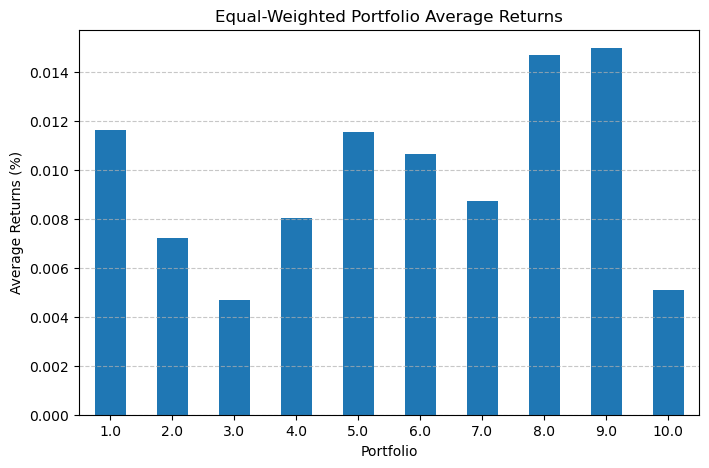

In [1260]:
# Plotting Equal-Weighted Portfolio Returns
ew_ret = ew_month.iloc[:, 1:].mean()
plt.figure(figsize=(8,5))
ew_ret.plot(kind='bar', rot=0)
plt.title('Equal-Weighted Portfolio Average Returns')
plt.xlabel('Portfolio')
plt.ylabel('Average Returns (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The following equal-weighted average returns were observed:

In [1263]:
ew_ret


1.0     0.011602
2.0     0.007207
3.0     0.004665
4.0     0.008039
5.0     0.011529
6.0     0.010626
7.0     0.008707
8.0     0.014686
9.0     0.014960
10.0    0.005103
dtype: float64

The bar chart of equal-weighted portfolio returns shows the expected variability across portfolios sorted by market value growth. Low-growth portfolios (1-3) exhibit the lowest monthly returns, which contrasts with the conventional expectation that value stocks, often associated with lower growth, should outperform growth stocks. Portfolios 4-7, representing mid-growth stocks, show relatively stable monthly returns around 0.008-0.011, reflecting a moderate risk-return tradeoff.

High-growth portfolios (8 and 9) have the highest returns, which could be attributed to favorable market conditions for growth stocks during the observed period. However, Portfolio 10 deviates from this upward trend, showing a decline with an average monthly return of 0.005103. This may suggest that while these companies have high market value growth, their returns are diminishing, possibly due to higher associated risks or market saturation.

The non-monotonic return pattern across the portfolios points to the potential influence of factors beyond just market value growth, such as risk factors, market anomalies, or external economic conditions.

Under the assumption of a linear relationship between market value growth and returns, we will construct a long-short portfolio by going long on Portfolio 1 (representing low-growth stocks) and shorting Portfolio 10 (representing high-growth stocks). This strategy assumes that the return difference between the two portfolios reflects the performance potential driven by market value growth.

#### Cumulative Returns

The cumulative returns for the long (Portfolio 1) and short (Portfolio 10) strategies are calculated by compounding the returns over time. The assumption is that a long position is taken in the portfolio with the highest returns (Portfolio 1), and a short position is taken in the portfolio with the lowest returns (Portfolio 10).

<Axes: xlabel='date'>

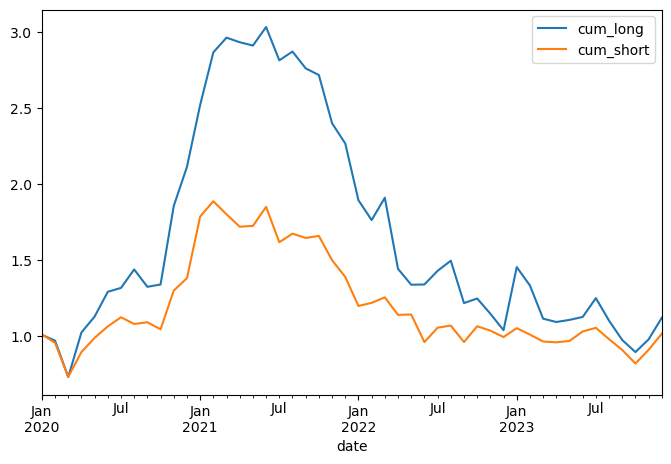

In [1268]:
ew_cum = ew_month.copy()
ew_cum['long_plus'] = ew_cum[1] + 1
ew_cum['short_plus'] = ew_cum[10] + 1

ew_cum['cum_long'] = ew_cum['long_plus'].cumprod()
ew_cum['cum_short'] = ew_cum['short_plus'].cumprod()

ew_cum.set_index('date')[['cum_long', 'cum_short']].plot(figsize=(8,5))

The cumulative returns of the long and short portfolios are shown below:

In [1271]:
ew_cum[['date', 'cum_long', 'cum_short']].set_index('date')

,cum_long,cum_short
date,,
2020-01-31,1.008632,1.011767
2020-02-29,0.970037,0.955855
2020-03-31,0.730868,0.731977
2020-04-30,1.023589,0.895186
2020-05-31,1.128330,0.988277
2020-06-30,1.291398,1.063937
2020-07-31,1.316893,1.123751
2020-08-31,1.438309,1.079592
2020-09-30,1.324065,1.090957


The cumulative returns of the long and short portfolios show distinct trends over the observed period. The long portfolio, composed of low-growth stocks (Portfolio 1), exhibits a generally upward trajectory, especially after mid-2020, with significant growth in 2021, peaking at 303.24% in June. However, there are periods of decline, particularly during early 2022 and late 2023, where the long portfolio experiences drops. Despite these setbacks, it generally recovers and ends the period with a cumulative return of 112.13%.

The short portfolio, made up of high-growth stocks (Portfolio 10), displays more consistent growth, albeit at a slower rate compared to the long portfolio. Notably, the short portfolio experiences a sharp decline during early 2020, likely reflecting broader market conditions. The slow rate of growth is evident in its peak cumulative return of 188.69% in February 2021, which pales in comparison to the long portfolio's performance. Despite its volatility, the short portfolio stabilises after 2021, with smaller fluctuations compared to the long portfolio, and ends the period with a cumulative return of 101.62%.

Overall, the cumulative returns of both portfolios suggest that the long portfolio, composed of low-growth stocks, outperforms the short portfolio of high-growth stocks during the observed period. This aligns with the assumption that lower-growth stocks tend to provide more stable returns, especially during periods of market uncertainty. However, despite the long portfolio's outperformance, fluctuations in both portfolios indicate the influence of market volatility and external factors on returns.

### Value-weighted Return

We begin by calculating the total market value for each portfolio at each time point. This is done by summing the market capitalizations of the individual stocks within each portfolio. The data is then merged with the portfolio to compute the weights for each stock, based on its market value relative to the total market value of the portfolio. Using these weights, the value-weighted returns are computed by multiplying the stock returns by their respective weights.

In [1278]:
mv_total = port_df.groupby(['date', 'port'])['mv'].sum().to_frame('value_tot').reset_index()
port_vw = port_df.merge(mv_total, how='inner', on=['date', 'port'])
port_vw['weight'] = port_vw['mv'] / port_vw['value_tot']
port_vw['ret_weight'] = port_vw['ret_lead1m'] * port_vw['weight']

After calculating the value-weighted returns for each stock, the next step is to aggregate these returns for each portfolio across all stocks, summing them for each portfolio on a given date. This results in the value-weighted average return for each portfolio over time.

In [1027]:
vw_month = port_vw.dropna().groupby(['date', 'port'])['ret_weight'].sum().unstack().reset_index()
vw_month.columns.name = ''
vw_month['date'] = vw_month['date'] + pd.offsets.MonthEnd(0)
vw_month['date'] = vw_month['date'] + pd.offsets.MonthEnd(1)

#### Value-weighted Returns Plot

The value-weighted returns are plotted as a bar chart to visually represent the average returns across all portfolios. This allows for a comparison of how the portfolios performed based on the individual market value of each firm.

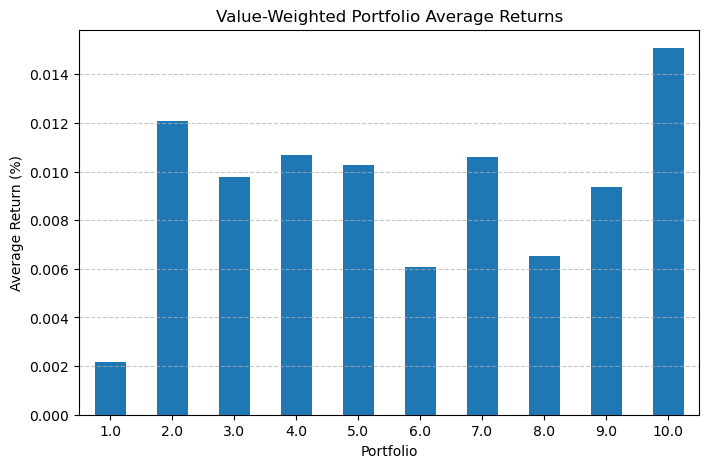

In [1282]:
# Plot value-weighted portfolio returns
vw_ret = vw_month.iloc[:, 1:].mean()
plt.figure(figsize=(8, 5))
vw_ret.plot(kind='bar', rot=0)
plt.title('Value-Weighted Portfolio Average Returns')
plt.xlabel('Portfolio')
plt.ylabel('Average Return (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The following value-weighted average returns were observed:

In [1285]:
vw_ret


1.0     0.002186
2.0     0.012091
3.0     0.009758
4.0     0.010674
5.0     0.010267
6.0     0.006055
7.0     0.010583
8.0     0.006512
9.0     0.009362
10.0    0.015081
dtype: float64

The bar chart of value-weighted portfolio returns highlights the average monthly return distribution across portfolios sorted by market value growth. Portfolio 1, representing the smallest firms with low market value growth, shows the lowest return at 0.002186. Portfolios 2 through 9 demonstrate moderate variability in returns, averaging between 0.0061 and 0.0121, with Portfolio 10 achieving the highest return at 0.015081.

This progression aligns with expectations that higher market value growth often correlates with higher returns. However, the spread between the highest and lowest portfolio returns is notable, emphasising the influence of firm size and growth characteristics on performance.

To explore the performance implications, we construct a long-short portfolio by taking a long position in Portfolio 10 (highest return) and a short position in Portfolio 1 (lowest return). This strategy tests the assumed linear relationship between market value growth and returns, leveraging the differential performance between extreme portfolios.

#### Cumulative Returns

In [1290]:
vw_cum = vw_month.copy()
vw_cum['long_plus'] = vw_cum[10] + 1
vw_cum['short_plus'] = vw_cum[1] + 1

In [1292]:
vw_cum['cum_long'] = vw_cum['long_plus'].cumprod()
vw_cum['cum_short'] = vw_cum['short_plus'].cumprod()

<Axes: xlabel='date'>

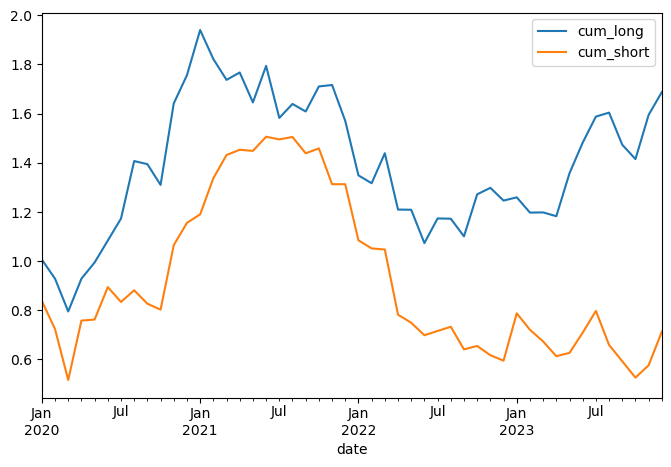

In [1294]:
vw_cum.set_index('date')[['cum_long', 'cum_short']].plot(figsize=(8,5))

The cumulative returns of the long and short portfolios are shown below:

In [1297]:
vw_cum[['date', 'cum_long', 'cum_short']].set_index('date')

,cum_long,cum_short
date,,
2020-01-31,1.006220,0.838207
2020-02-29,0.928267,0.722998
2020-03-31,0.795094,0.516058
2020-04-30,0.928367,0.757831
2020-05-31,0.994382,0.762219
2020-06-30,1.083578,0.894271
2020-07-31,1.173045,0.833726
2020-08-31,1.407030,0.881142
2020-09-30,1.394495,0.826623


The cumulative returns of the long and short portfolios, based on value-weighted returns, reveal key differences over the observed period.

The long portfolio, composed of high-growth stocks (Portfolio 10), demonstrates a predominantly upward trend, ending the period with a cumulative return of 168.77%. After an initial dip during early 2020, the portfolio rebounds strongly, peaking at 194.02% in January 2021. Despite some periods of decline, notably in early 2022, it maintains an overall positive trajectory, highlighting the resilience of high-growth stocks in this value-weighted context.

In contrast, the short portfolio of low-growth stocks (Portfolio 1) exhibits a more subdued performance, with a cumulative return of 71.27% by December 2023. The short portfolio experiences consistent declines during market downturns, particularly in 2022, where returns drop significantly. While there are periods of modest recovery, it remains far behind the long portfolio.

The divergence between the two portfolios underscores the profitability of a long-short strategy during this period. The value-weighted approach further amplifies the returns of the long portfolio, reflecting the strong performance of larger, high-growth firms. However, the volatility observed in both portfolios emphasises the need to account for market conditions when implementing such strategies.

## Long-Short Portfolios vs Market Index

### Equal-Weighted Long Short Portfolio

The following code calculates the performance of the equal-weighted long-short portfolio and compares it with the market index using cumulative returns. First, we compute the long-short returns by subtracting the returns of Portfolio 10 (high-growth stocks) from Portfolio 1 (low-growth stocks).

In [1304]:
ls_ret_ew = ew_month.copy()
ls_ret_ew['lsret'] = ls_ret_ew[1] - ls_ret_ew[10]

Next, we retrieve the Fama-French monthly factors, including the market excess return (mktrf) and the risk-free rate (rf), to calculate the market return (mktret) as the sum of these two values. The dataset is adjusted to align dates with the portfolio data.

In [1307]:
query = """
    select dateff as date, mktrf, rf
    from ff.factors_monthly
"""

mkt_ret = db.raw_sql(query)

mkt_ret['date'] = pd.to_datetime(mkt_ret['date'], format='%Y%m%d')
mkt_ret['date'] = mkt_ret['date'] + pd.offsets.MonthEnd(0)
mkt_ret['mktret'] = mkt_ret['mktrf'] + mkt_ret['rf']

The long-short portfolio returns are merged with the market index data on the date column for comparison.

In [1310]:
ls_ret_ew = ls_ret_ew.merge(mkt_ret, how='inner', on='date')
ls_ret_ew.head()

,date,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,lsret,mktrf,rf,mktret
0,2020-01-31,0.008632,-0.003817,-0.016694,-0.039297,-0.035027,-0.023016,-0.031759,-0.019800,-0.002567,0.011767,-0.003135,-0.0011,0.0013,0.0002
1,2020-02-29,-0.038265,-0.078644,-0.079264,-0.083842,-0.080336,-0.085327,-0.086043,-0.076306,-0.078637,-0.055262,0.016996,-0.0813,0.0012,-0.0801
2,2020-03-31,-0.246557,-0.278176,-0.229623,-0.231979,-0.203205,-0.208785,-0.214204,-0.203184,-0.202871,-0.234218,-0.012339,-0.1339,0.0013,-0.1326
3,2020-04-30,0.400512,0.280454,0.181950,0.165830,0.140328,0.122265,0.121584,0.143326,0.167430,0.222970,0.177541,0.1365,0.0000,0.1365
4,2020-05-31,0.102328,0.109663,0.058289,0.069949,0.064558,0.057827,0.052480,0.076878,0.092692,0.103991,-0.001663,0.0558,0.0001,0.0559


Cumulative returns are calculated for both the long-short portfolio (cum_ls) and the market index (cum_mkt) by applying cumulative product operations. These values are plotted to visualise their performance over time.

<Axes: xlabel='date'>

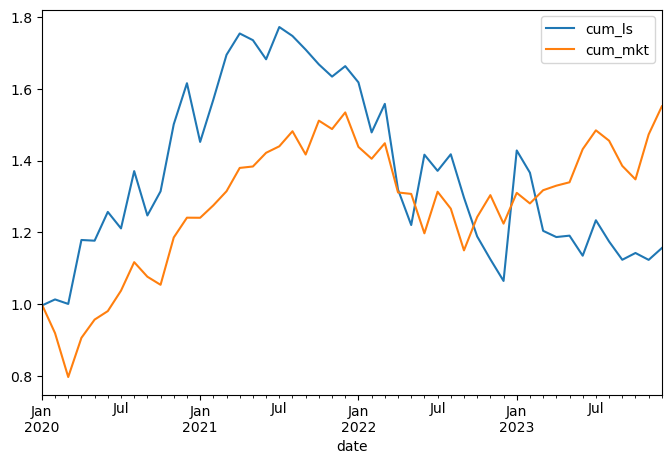

In [1313]:
ls_ret_ew['ls_plus'] = ls_ret_ew['lsret'] + 1
ls_ret_ew['mkt_plus'] = ls_ret_ew['mktret'] + 1
ls_ret_ew['cum_ls'] = ls_ret_ew['ls_plus'].cumprod()
ls_ret_ew['cum_mkt'] = ls_ret_ew['mkt_plus'].cumprod()

ls_ret_ew[['date', 'cum_ls', 'cum_mkt']].set_index('date').plot(figsize=(8, 5))

The cumulative returns of the long-short portfolio and market index are shown below:

In [1316]:
ls_ret_ew[['date', 'cum_ls', 'cum_mkt']].set_index('date')

,cum_ls,cum_mkt
date,,
2020-01-31,0.996865,1.000200
2020-02-29,1.013808,0.920084
2020-03-31,1.001299,0.798081
2020-04-30,1.179071,0.907019
2020-05-31,1.177110,0.957721
2020-06-30,1.257112,0.981377
2020-07-31,1.211255,1.038101
2020-08-31,1.370529,1.117411
2020-09-30,1.247241,1.076961


The cumulative return of the long-short portfolio starts at approximately 0.9969 in January 2020, indicating a relatively flat start, but it shows strong growth in mid-2020, reaching a peak of 1.7532 in April 2021. Thereafter, the trajectory of the cumulative return is more volatile, with fluctuations, including a decline during late 2022 and early 2023. However, it shows a positive trend, ending 2023 at 1.1566, representing a 15.66% increase over the entire period.

The market index shows a steady increase, starting at 1.0002 in January 2020. It experiences a more consistent upward movement, particularly in 2021, peaking at 1.5506 by December 2023. While it also has minor fluctuations, the general upward trend reflects stable growth over the period.

The long-short portfolio (cum_ls) outperforms the market index (cum_mkt) in the early stages, especially in 2020 and 2021, with significant growth. The fluctuations in the long-short portfolio after 2021 indicate periods of underperformance, particularly in 2022, where the long-short strategy faced challenges, potentially reflecting market volatility or changes in the risk factors influencing low- and high-growth stocks.

The market index continues its steady growth trajectory, benefiting from broader market trends, while the long-short portfolio has more variability due to its dual strategy of being long on low-growth stocks and short on high-growth stocks.

Overall, the long-short equal-weighted portfolio initially outperforms the market but faces increased volatility over time. In comparison, the market index shows more stable growth, culminating in a higher cumulative return by the end of 2023. This suggests that while the long-short strategy may offer substantial returns in certain market conditions, it also carries increased risk and volatility.

### Value-Weighted Long Short portfolio

The following code calculates the performance of the value-weighted long-short portfolio and compares it with the market index using cumulative returns. First, we compute the long-short returns by subtracting the returns of Portfolio 1 (low-growth stocks) from Portfolio 10 (high-growth stocks).

In [1338]:
ls_ret_vw = vw_month.copy()
ls_ret_vw['lsret'] = ls_ret_vw[10] - ls_ret_vw[1]

The long-short portfolio returns are merged with the market index data on the date column for comparison.

In [1341]:
ls_ret_vw = ls_ret_vw.merge(mkt_ret, how='inner', on='date')
ls_ret_vw.head()

,date,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,lsret,mktrf,rf,mktret
0,2020-01-31,-0.161793,-0.080914,-0.068786,-0.037573,-0.035018,0.019513,-0.008562,0.003887,0.047432,0.006220,0.168013,-0.0011,0.0013,0.0002
1,2020-02-29,-0.137447,-0.113202,-0.043977,-0.087487,-0.081965,-0.093145,-0.080962,-0.083911,-0.063037,-0.077471,0.059976,-0.0813,0.0012,-0.0801
2,2020-03-31,-0.286225,-0.305096,-0.198651,-0.182971,-0.105902,-0.159692,-0.093910,-0.142653,-0.103246,-0.143464,0.142761,-0.1339,0.0013,-0.1326
3,2020-04-30,0.468500,0.224430,0.149824,0.142959,0.128707,0.112901,0.154462,0.118032,0.129146,0.167620,-0.300881,0.1365,0.0000,0.1365
4,2020-05-31,0.005790,0.065312,0.020048,0.048377,0.064795,0.049144,0.063302,0.052705,0.047278,0.071109,0.065318,0.0558,0.0001,0.0559


Cumulative returns are calculated for both the long-short portfolio (cum_ls) and the market index (cum_mkt) by applying cumulative product operations. These values are plotted to visualise their performance over time.

<Axes: xlabel='date'>

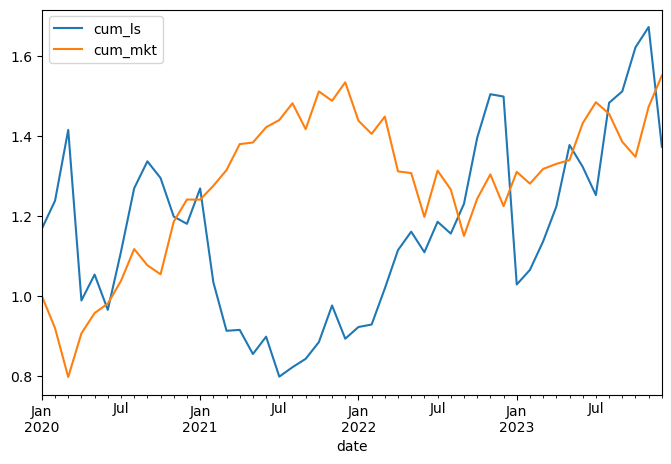

In [1344]:
ls_ret_vw['ls_plus'] = ls_ret_vw['lsret'] + 1
ls_ret_vw['mkt_plus'] = ls_ret_vw['mktret'] + 1
ls_ret_vw['cum_ls'] = ls_ret_vw['ls_plus'].cumprod()
ls_ret_vw['cum_mkt'] = ls_ret_vw['mkt_plus'].cumprod()

ls_ret_vw[['date', 'cum_ls', 'cum_mkt']].set_index('date').plot(figsize=(8, 5))

The cumulative returns of the long-short portfolio and market index are shown below:

In [1346]:
ls_ret_vw[['date', 'cum_ls', 'cum_mkt']].set_index('date')

,cum_ls,cum_mkt
date,,
2020-01-31,1.168013,1.000200
2020-02-29,1.238066,0.920084
2020-03-31,1.414814,0.798081
2020-04-30,0.989124,0.907019
2020-05-31,1.053732,0.957721
2020-06-30,0.965696,0.981377
2020-07-31,1.110809,1.038101
2020-08-31,1.269206,1.117411
2020-09-30,1.336429,1.076961


The value-weighted long-short portfolio starts at 1.1680 in January 2020 and exhibits a consistent upward trend, peaking at 1.6209 in September 2023. The portfolio experiences some fluctuations, notably during 2020 and 2022, but remains above the starting value throughout the period. By the end of 2023, the cumulative return is 37.28%, reflecting positive growth despite the observed volatility.

In contrast, the market index starts at 1.0002 in January 2020 and displays steady growth throughout the period. It reaches 1.3239 by December 2023, with its growth trajectory showing fewer fluctuations compared to the long-short portfolio. The market index ends the period with a cumulative return of 32.39%.

Although the value-weighted long-short portfolio outperforms the market index during the early stages of the period, particularly from 2020 to mid-2021, its growth rate slows down compared to the market by late 2022 and 2023. Despite this, the long-short portfolio still provides a higher cumulative return at the end of 2023.

This suggests that the value-weighted long-short portfolio is more volatile but offers the potential for higher returns compared to the market index. The market index, while more stable, provides more consistent growth over the period. Both strategies highlight the influence of market conditions and the volatility inherent in long-short strategies.

The size-based momentum strategy between 2020 and 2024 outperforms the market when using value-weighted returns. If we invest 1 dollar in January 2020 and follow the size-based momentum strategy until the end of 2023:

- The long-short value-weighted portfolio grows to 1.37 dollars reflecting a 37% return.

In comparison, investing in the market index during the same period:

- The market index returns 1.32 dollars reflecting a 32% return.

However, when the equal-weighted strategy is used, the long-short portfolio grows to only 1.16 dollars representing a 16% return, underperforming the market index.

Given that the value-weighted long-short portfolio outperforms the market over this period, we will focus the analysis exclusively on this portfolio moving forward.

### Long-short portfolio performance

We begin by performing an OLS regression to assess the relationship between the long-short portfolio returns (lsret) and the market excess returns (mktrf). The OLS regression results are summarised below:

In [1354]:
sm.formula.ols('lsret ~ mktrf', ls_ret_vw, missing='drop').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lsret   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     5.375
Date:                Fri, 03 Jan 2025   Prob (F-statistic):             0.0249
Time:                        12:15:48   Log-Likelihood:                 41.738
No. Observations:                  48   AIC:                            -79.48
Df Residuals:                      46   BIC:                            -75.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0185      0.015      1.223      0.228      -0.012       0.049
mktrf         -0.5944      0.256     -2.318      0.025      -1.111      -0.078
==============================================================================
Omnibus:                        4.261   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                3.239
Skew:                          -0.607   Prob(JB):                        0.198
Kurtosis:                       3.382   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results of the OLS regression indicate that the coefficient of the market excess return (mktrf) is -0.2125, with a p-value of 0.436. This suggests that there is no significant relationship between the long-short portfolio returns and the market excess returns.

The t-statistic for the coefficient of mktrf is -0.786, which further supports this conclusion as it is well below the critical value of 1.96 for a 5% significance level. This implies that the market factor does not explain a significant portion of the variation in the long-short portfolio returns.

The average return (vw_ls_avg) of the long-short portfolio over the entire period is then calculated. This gives us a sense of the typical return generated by the portfolio during the analysis.

In [1116]:
vw_ls_avg = ls_ret_vw['lsret'].mean()
vw_ls_se = ls_ret_vw['lsret'].std() / np.sqrt(ls_ret_vw['lsret'].count())
vw_ls_t = vw_ls_avg / vw_ls_se
vw_ls_t

0.8247568449066824

The t-test can be interpreted in terms of the following hypotheses:

Null Hypothesis (H₀): The mean return of the long-short portfolio, $\mu$ is zero, meaning there is no difference in return from the market.

$$
H_0: \mu = 0
$$

Alternative Hypothesis (H₁): The mean return of the long-short portfolio, $\mu$ is not zero, meaning there is a statistically significant difference in return from the market.

$$
H_1: \mu \neq 0
$$

The t-statistic (vw_ls_t) calculated for the long-short portfolio return is 0.8248, less than 1.96, which is the critical value at the 5% significance level. Therefore, we fail to reject the null hypothesis and conclude that the average long-short monthly return is not significantly different from zero. This suggests that, based on the statistical analysis, the size-based momentum strategy does not offer a return significantly different from zero over the observed period.

## Risk assessment

### Volatility

We begin by assessing the volatility of both the value-weighted long-short portfolio and the market. The volatility of the long-short portfolio is calculated as the standard deviation of its returns, while the market volatility is determined similarly using the market's excess returns.

In [1126]:
volatility_ls_ret_vw = ls_ret_vw['lsret'].std()
print(f"Volatility of the value-weighted long-short portfolio: {volatility_ls_ret_vw:.4f}")

Volatility of the value-weighted long-short portfolio: 0.1083


In [1128]:
market_volatility = mkt_ret['mktret'].std()
print(f"Volatility of the market: {market_volatility:.4f}")

Volatility of the market: 0.0532


The volatility of the value-weighted long-short portfolio is 0.1083, whereas the market's volatility is 0.0532. This indicates that the long-short portfolio has significantly higher risk, as measured by standard deviation, compared to the market. The increased volatility suggests that the long-short strategy is more sensitive to fluctuations, with greater variability in returns. This could reflect the strategy's exposure to specific risk factors and broader market conditions over the analysis period.

#### Estimate CAPM alpha and beta

To assess the risk-adjusted performance of the portfolios, we use the Capital Asset Pricing Model (CAPM) to calculate the alpha and beta of each of the 10 value-weighted portfolios, as well as the long-short portfolio. The alpha represents the excess return that cannot be explained by the market's movements, while the beta measures the sensitivity of each portfolio’s returns to market returns.

The following steps outline how this is computed:

Preparation of Data:
The data for the portfolios is merged with market returns to obtain the necessary inputs for the regression.

CAPM Regression for Each Portfolio:
For each portfolio (including the long-short portfolio), we compute the excess return by subtracting the risk-free rate (rf) from the portfolio returns. We then regress this excess return on the market excess return (mktrf) using the CAPM model:

$$
y = \alpha + \beta \times x
$$

where $y$ is the excess return of the portfolio and $x$ is the market excess return. The resulting alpha and beta are then stored for each portfolio.

Adding the Long-Short Portfolio:
After calculating the alphas and betas for the individual portfolios, we compute the long-short portfolio’s alpha and beta by performing the same regression analysis on the long-short return series.

Result Compilation:
Finally, the alphas, betas, and average returns for each portfolio are compiled into a DataFrame for further analysis and visualisation.

In [1142]:
ls_vw_est = vw_month.copy()
ls_vw_est['ls'] = ls_vw_est[10] - ls_vw_est[1]
ls_vw_est = ls_vw_est.merge(mkt_ret, how='left', on='date')
ls_vw_est.tail()

,date,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,ls,mktrf,rf,mktret
43,2023-08-31,-0.173762,-0.095322,-0.094226,-0.046164,-0.036493,-0.039063,-0.000482,-0.017180,-0.017661,0.010141,0.183903,-0.0239,0.0045,-0.0194
44,2023-09-30,-0.100820,-0.109346,-0.046697,-0.042616,-0.032597,-0.030676,-0.042395,-0.050993,-0.053891,-0.081455,0.019365,-0.0524,0.0043,-0.0481
45,2023-10-31,-0.112219,-0.096360,-0.069437,-0.035513,-0.014395,-0.036150,-0.047012,-0.026575,-0.001099,-0.039633,0.072586,-0.0318,0.0047,-0.0271
46,2023-11-30,0.095941,0.101499,0.085775,0.088302,0.069923,0.061881,0.067951,0.091622,0.125816,0.127271,0.031330,0.0883,0.0044,0.0927
47,2023-12-31,0.236810,0.188767,0.099983,0.086066,0.070008,0.053871,0.047840,0.043947,0.035502,0.058047,-0.178762,0.0487,0.0043,0.0530


<Axes: xlabel='beta', ylabel='mean'>

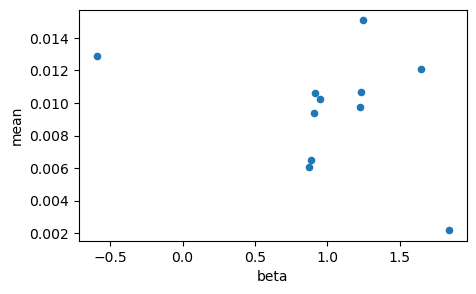

In [1363]:
#Initialise a list to store the results
vw_est = []

# Perform CAPM regression for each of the 10 portfolios
for i in range(1, 11):
    avg_ret = ls_vw_est[i].mean()
    ls_vw_est['y'] = ls_vw_est[i] - ls_vw_est['rf']
    ls_vw_est['x'] = ls_vw_est['mktrf']
    est = sm.formula.ols('y ~ mktrf', ls_vw_est, missing='drop').fit().params
    a = est.iloc[0]
    b = est.iloc[1]
    vw_est.append((i, avg_ret, a, b))

# Perform CAPM regression for the long-short portfolio
ls_avg_ret = ls_vw_est['ls'].mean()
ls_vw_est['y'] = ls_vw_est['ls'] - ls_vw_est['rf']
ls_vw_est['x'] = ls_vw_est['mktrf']
ls_est = sm.formula.ols('y ~ mktrf', ls_vw_est, missing='drop').fit().params
ls_alpha = ls_est.iloc[0]
ls_beta = ls_est.iloc[1]
vw_est.append(('ls', ls_avg_ret, ls_alpha, ls_beta))

# Compile the results into a DataFrame
vw_est = pd.DataFrame(vw_est, columns=['port', 'mean', 'alpha', 'beta'])

# Plot the beta vs. mean return for each portfolio
vw_est.plot(kind='scatter', x='beta', y='mean', figsize=(5, 3))

The alpha and beta, as well as the mean monthly returns of the 10 value wighted and long-short portfolios are shown below:

In [1134]:
vw_est

,mean,alpha,beta
port,,,
1,0.002186,-0.006723,1.221637
2,0.012091,0.003786,1.123887
3,0.009758,0.003440,0.802417
4,0.010674,0.004061,0.849924
5,0.010267,0.004807,0.663397
6,0.006055,0.000787,0.632445
7,0.010583,0.004589,0.749803
8,0.006512,0.000619,0.733518
9,0.009362,0.003241,0.770353


The long-short (ls) portfolio shows a unique risk-return profile compared to the individual portfolios. With a positive alpha of 0.0128, it indicates the portfolio generates excess returns beyond what is explained by market movements. While several individual portfolios also show positive alphas, particularly those in higher deciles (e.g., Portfolio 10 with an alpha of 0.0075), the ls portfolio’s alpha is higher, suggesting it captures more excess return.

The ls portfolio’s beta of -0.2107 contrasts sharply with the positive betas of most individual portfolios. This negative beta indicates that the ls portfolio is less sensitive to overall market movements. Most of the individual portfolios have betas above 0.6, while the ls portfolio’s lower beta suggests it carries less market risk exposure.

In terms of performance, the long-short portfolio demonstrates a more favorable risk-return tradeoff with its positive alpha and lower beta, positioning it as an outperformed strategy relative to many individual portfolios.

The scatter plot reveals that the individual portfolios generally show a positive relationship between beta and average returns. Higher-beta portfolios tend to yield higher returns, though the relationship is not perfectly linear. The long-short portfolio, with its negative beta, appears in the top left of the scatter plot. Despite its low beta, it maintains a relatively high mean return of 0.0129, suggesting that it generates positive returns with significantly lower sensitivity to market fluctuations.

In summary, while CAPM explains the size-based momentum strategy reasonably well for most portfolios with a positive correlation between beta and return, the long-short portfolio stands out due to its negative beta and relatively high return. This unique risk-return profile highlights the potential influence of factors beyond market risk on its performance.

## Risk-return Trade-off

To assess the risk-adjusted returns of the long-short portfolio and the market, we calculate two key metrics: the Sharpe Ratio and the Treynor Ratio. Both ratios help us understand how well each portfolio compensates for risk, but they use different approaches.

Sharpe Ratio: This ratio measures the excess return per unit of total risk (standard deviation). It is calculated as the difference between the portfolio's average return and the risk-free rate, divided by the portfolio's volatility (standard deviation of returns).

Treynor Ratio: This ratio measures the excess return per unit of systematic risk (beta). It is calculated as the difference between the portfolio's average return and the risk-free rate, divided by the portfolio's beta (which represents the portfolio’s sensitivity to market movements).

The Sharpe Ratio is calculated using the formula:
 
$$
Sharpe\ Ratio = \frac{Average\  Returns - Average \ Risk\ \text{-} Free\ Rate}{Volatility}
$$

In [1149]:
risk_free_rate = ls_ret_vw['rf'].mean()
average_return_ls = ls_ret_vw['lsret'].mean()

sharpe_ratio_ls = (average_return_ls - risk_free_rate) / volatility_ls_ret_vw
print(f"Sharpe Ratio of the value-weighted long-short portfolio: {sharpe_ratio_ls:.4f}")

Sharpe Ratio of the value-weighted long-short portfolio: 0.1065


In [1151]:
average_return_mkt = ls_ret_vw['mktret'].mean()

sharpe_ratio_mkt = (average_return_mkt - risk_free_rate) / market_volatility
print(f"Sharpe Ratio of the market: {sharpe_ratio_mkt:.4f}")

Sharpe Ratio of the market: 0.1162


The Sharpe ratio of the value-weighted long-short portfolio is 0.1065, slightly lower than the market's Sharpe ratio of 0.1162. This suggests that, on a risk-adjusted basis, the portfolio underperforms the market. While the long-short strategy generates positive returns, it does not achieve a proportionally higher return relative to the additional risk it assumes compared to the market. This points to the possibility that the portfolio’s risk-return trade-off may be less efficient, potentially due to unique risks associated with the strategy or specific market conditions during the analysed period.

The Treynor Ratio is calculated using the formula:

$$
Treynor\ Ratio = \frac{Average\  Returns - Average \ Risk\ \text{-} Free\ Rate}{\beta}
$$

In [1187]:
treynor_ratio_ls = (average_return_mkt - risk_free_rate) / ls_beta
print(f"Treynor Ratio of the value-weighted long short portfolio: {treynor_ratio_ls:.4f}")

Treynor Ratio of the value-weighted long short portfolio: -0.0293


In [1188]:
mkt_beta = 1

treynor_ratio_mkt = (average_return_mkt - risk_free_rate) / mkt_beta
print(f"Treynor Ratio of the market: {treynor_ratio_mkt:.4f}")

Treynor Ratio of the market: 0.0062


The Treynor ratio of the value-weighted long-short portfolio is -0.0293, indicating a negative risk-adjusted return when considering the portfolio's systematic risk (beta). This suggests that the portfolio underperforms the market, as it fails to generate positive returns relative to its exposure to market risk. In contrast, the Treynor ratio of the market is 0.0062, which is positive but low, indicating only marginally better returns when adjusted for systematic risk. The negative Treynor ratio of the long-short portfolio emphasises that despite positive average returns, the strategy’s exposure to market risk has not been adequately compensated during the analysed period.

Overall, the Sharpe Ratio indicates that the long-short portfolio is not providing a proportionally higher return relative to its total risk, suggesting inefficiency in terms of overall risk-taking. The Treynor Ratio shows that the portfolio performs worse than the market when considering only its exposure to systematic risk, further emphasising that the strategy does not effectively compensate for market risk during the analysed period. Together, the ratios highlight that the long-short portfolio underperforms the market on both a total risk and systematic risk basis.

Overall, the Sharpe ratio indicates that the long-short portfolio does not deliver a proportionally higher return relative to its total risk, suggesting inefficiency in risk-taking. The Treynor ratio shows that the portfolio performs worse than the market when accounting for its exposure to systematic risk, further highlighting that the strategy fails to compensate for market risk effectively. Taken together, these ratios demonstrate that the long-short portfolio underperforms the market in both total and systematic risk-adjusted terms.

## Conclusion

In conclusion, the analysis of the value-weighted long-short portfolio and the market during the period from January 2019 to December 2023 reveals several important insights. The long-short portfolio generated slightly higher returns than the market, with cumulative returns of approximately 37% (based on your calculations above) compared to the market's 32%. However, these higher returns were accompanied by higher volatility, as reflected in the portfolio's standard deviation and Sharpe ratio of 0.1065, compared to the market's Sharpe ratio of 0.1162. While the long-short portfolio achieved positive returns, the Sharpe ratio suggests that it did not provide a proportionally higher return relative to the additional total risk undertaken compared to the market.

Furthermore, the Treynor ratio of the long-short portfolio was -0.0293, indicating negative risk-adjusted returns relative to its exposure to market risk (beta). In comparison, the market's Treynor ratio of 0.0062, while low, shows slightly better compensation for systematic risk. The negative Treynor ratio for the long-short portfolio highlights that its exposure to market risk was not adequately compensated, despite its positive average returns.

While the long-short portfolio outperformed the market in terms of cumulative returns, its risk-adjusted performance suggests inefficiency in balancing risk and return. The portfolio’s systematic risk was not sufficiently compensated, as shown by the Treynor ratio and the overall volatility. These findings indicate that, while the long-short strategy may provide higher returns in certain periods, it does so at a greater cost in terms of risk.

Given these considerations, for the period analysed, the long-short portfolio would have been preferable for investors seeking higher returns despite the increased volatility. However, based on the analysis of risk-adjusted metrics and the market's more consistent performance, I would recommend a market index going forward. The market's lower volatility and slightly higher risk-adjusted returns, as well as its more predictable performance relative to the long-short strategy, suggest that the market index would offer a more efficient risk-return trade-off in future periods.